#Download Dataset

In [ ]:
# Dataset URL
# https://zenodo.org/record/4726653
!wget https://zenodo.org/record/4726653/files/plantnet_300K.zip


# Import Tensorflow 

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pprint
import json
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score


import tensorflow_datasets as tfds

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image

In [ ]:
!pip install git+https://github.com/tensorflow/docs


In [ ]:
import tensorflow_docs as tdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [ ]:

!unzip plantnet/plantnet_300K.zip

In [ ]:
ls plantnet_300K/

images_test/   images_val/                 plantnet300K_species_names.json
images_train/  plantnet300K_metadata.json  README


In [ ]:
 # Check species classes vs folder names
FOLDER_TO_CLASS_JSON = "plantnet_300K/plantnet300K_species_names.json"

with open(FOLDER_TO_CLASS_JSON) as f:
  class_dict = json.load(f)
class_list = list(class_dict.values())

print(str(len(class_list)) + " classes found in dataset")
#cat plantnet_300K/plantnet300K_species_names.json

1081 classes found in dataset


# Create Datasets for training process






In [ ]:
SEED = 123
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

TRAIN_FOLDER = "plantnet_300K/images_train/"
VALIDATION_FOLDER = "plantnet_300K/images_val/"
TEST_FOLDER = "plantnet_300K/images_test/"

In [ ]:
AUTO = tf.data.experimental.AUTOTUNE

train_dataset_raw = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_FOLDER, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=True, seed=SEED,
    interpolation='bilinear', follow_links=False, smart_resize=True
)
val_dataset_raw = tf.keras.preprocessing.image_dataset_from_directory(
    VALIDATION_FOLDER, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=BATCH_SIZE, image_size=IMAGE_SIZE,
     shuffle=True, seed=SEED,
    interpolation='bilinear', follow_links=False, smart_resize=True
)

test_dataset_raw = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_FOLDER, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=BATCH_SIZE, image_size=IMAGE_SIZE,
     shuffle=True, seed=SEED,
    interpolation='bilinear', follow_links=False, smart_resize=True
)

@tf.function
def process_dataset(image, label):

  image = image/127.0 - 1 #normalize around -1 to +1
  return(image, label)

train_dataset = train_dataset_raw.map(process_dataset, num_parallel_calls=AUTO)
val_dataset = val_dataset_raw.map(process_dataset, num_parallel_calls=AUTO)
test_dataset = test_dataset_raw.map(process_dataset, num_parallel_calls=AUTO)

Found 243916 files belonging to 1081 classes.
Found 31118 files belonging to 1081 classes.
Found 31112 files belonging to 1081 classes.


## Method 1 Plot Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


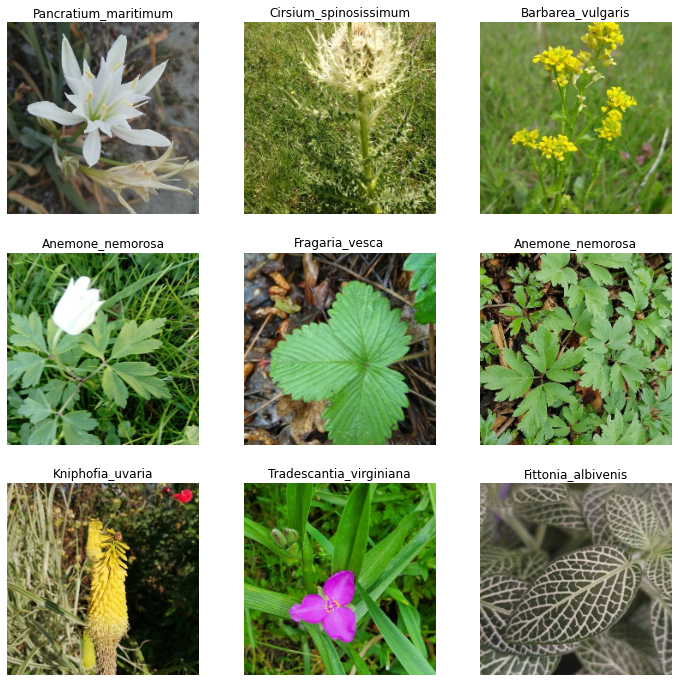

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        image = (images[i].numpy() + 1)/ 2.0
        plt.imshow(image)
        plt.title(class_list[np.argmax(labels[i])])
        plt.axis("off")

# Model Creation



In [ ]:

base_model = tf.keras.applications.MobileNetV2(
    input_shape = (224,224,3),
    alpha=1.0,
    include_top=False,
    weights="imagenet",
    pooling=None,
    classifier_activation="softmax",
)



## Add Final 3 layers to base model
Bunlar, temel modeli dondursak bile kendi özel verilerimizi sınıflandırmamıza yardımcı olacaktır. Ayrıca son katman, sınıflandırma etiketlerimizin boyutuyla eşleşecek 1081 düğüme sahiptir.



In [ ]:
# Let's add final trainable layers to learn our specific data
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(1081, activation="softmax")(x)

## Finish creating complete model



In [ ]:
model = Model(inputs = base_model.input, outputs = predictions)

## Freeze the model middle layers
 Bu parametrenin değiştirilmesi, model oluşturulduktan sonra yapılmalıdır, aksi takdirde düzgün şekilde eğitilmez.



In [ ]:

FREEZE_LAYERS = False 

base_model.trainable = not FREEZE_LAYERS
print("Model is trainable: " + str(base_model.trainable))

Model is trainable: True


# Set Up Optimizer


In [ ]:
OPTIMIZER = "rmsprop"


opt = 'rmsprop'

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics= ["accuracy", 'top_k_categorical_accuracy'])

#Plot the Model
Warning: Usually very long

In [ ]:
PLOT_MODEL = False

if PLOT_MODEL:
  tf.keras.utils.plot_model(
      model, to_file='model.png', show_shapes=True, show_dtype=True,
      show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
  )

# Load Previous Model

In [ ]:
from datetime import datetime 

GDRIVE_DIR = "/content/drive/MyDrive/saved_models/"
filepath = "/content/drive/MyDrive/saved_models/plantNet_32_rmsprop_0.01_2021-08-20.h5"


# Date Time
current_time = datetime.now().strftime('%Y-%m-%d_%H:%M:%S')
current_date = datetime.now().strftime('%Y-%m-%d')

# Try loading model at filepath to continue training
# If no file exists then it creates a new one
try:
  model = keras.models.load_model(filepath)
  print("Continuing training from checkpoint at {}".format(filepath))
except:
  print("No keras model found at {}, will start training from scratch.".format(filepath))
  filepath = "{0}plantNet_{1}_{2}_{3}_{4}.h5".format(GDRIVE_DIR, BATCH_SIZE, OPTIMIZER, LEARNING_RATE, current_date)
  
  print("New model filename is {}".format(filepath))

No keras model found at , will start training from scratch.
New model filename is /content/drive/MyDrive/saved_models/plantNet_32_rmsprop_0.01_2021-08-20.h5


# Set Up Callbacks

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Save model only when validation accuracy increases
# checkpoint = ModelCheckpoint(filepath, monitor="val_acc", verbose=1, save_best_only=True, mode="max")
checkpoint = ModelCheckpoint(filepath, save_best_only=False, save_weights_only=False)

# Tensorboard callback
logdir = GDRIVE_DIR + "logs/" + current_time
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1, write_images=True, embeddings_freq=1)

# Stop training model if validation loss does not improve for 3 epochs
earlyStopping = EarlyStopping(monitor="val_loss", patience=5, verbose=1)

callbacks_list = [checkpoint, earlyStopping, tensorboard_callback]



# Train Model

In [ ]:
epochs = 5
steps_per_epoch = None
# val_dataset = None
history = model.fit(train_dataset, validation_data=val_dataset, epochs=epochs, callbacks=callbacks_list, steps_per_epoch=steps_per_epoch)



/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/5
7623/7623 [==============================] - 5072s 664ms/step - loss: 3.4224 - accuracy: 0.3537 - top_k_categorical_accuracy: 0.5860 - val_loss: 5.1833 - val_accuracy: 0.3157 - val_top_k_categorical_accuracy: 0.5377
Epoch 2/5
7623/7623 [==============================] - 5051s 663ms/step - loss: 3.0300 - accuracy: 0.4393 - top_k_categorical_accuracy: 0.6665 - val_loss: 4.2700 - val_accuracy: 0.3118 - val_top_k_categorical_accuracy: 0.5240
Epoch 3/5
7623/7623 [==============================] - 5054s 663ms/step - loss: 2.9474 - accuracy: 0.4685 - top_k_categorical_accuracy: 0.6889 - val_loss: 3.5502 - val_accuracy: 0.4098 - val_top_k_categorical_accuracy: 0.6258
Epoch 4/5
7623/7623 [==============================] - 5041s 661ms/step - loss: 2.8970 - accuracy: 0.4857 - top_k_categorical_accuracy: 0.7022 - val_loss: 3.4359 - val_accuracy: 0.4414 - val_top_k_categorical_accuracy: 0.6577
Epoch 5/5
2771/7623 [=========>....................] - ETA: 51:28 - loss: 2.8605 - accuracy: 0.4

# Save model

In [ ]:
import coremltools as ct
import numpy as np

from tensorflow import keras
IMAGE_INPUT_NAME = ["input:0"]
IMAGE_INPUT_NAME_SHAPE = {'input:0':[1,224,224,3]}
IMAGE_INPUT_SCALE = 1.0/255.0
OUTPUT_NAME = ['MobilenetV2/Predictions/Reshape_1:0']
MODEL_LABELS = '/content/llabel2.txt'
TF_FROZEN_MODEL = '/content/PlantKerasModel.h5'



CORE_ML_MODEL = "PlantX.mlmodel"


keras_model = keras.models.load_model(TF_FROZEN_MODEL,compile=False)

coreml_model = ct.convert(keras_model,
                        inputs = [ct.ImageType(bias=[-1,-1,-1], scale=1/127)],
                         classifier_config = ct.ClassifierConfig(MODEL_LABELS)
                             )

coreml_model.author = 'Rabia Abdioğlu'
coreml_model.short_description = 'Plant classifier model'
coreml_model.version= '1.0'


coreml_model.save(CORE_ML_MODEL)